In [1]:
# Import Libraries
import pyspark
from pyspark.sql import SparkSession
import mlflow
import sys
import time
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import mlflow.spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# **Data Wrangling**

In [2]:
# Inisialisasi sesi Spark
spark = SparkSession.builder\
    .appName("SentimentAnalysis")\
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.python.worker.reuse", "true") \
    .getOrCreate()

In [3]:
#Load Data

data_path = "C:/Users/elsap/OneDrive/Dokumen/KP/Data/Rio by the Beach.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [4]:
# Exploratory data analysis

df.printSchema()

root
 |-- NBa7we src: string (nullable = true)
 |-- d4r55: string (nullable = true)
 |-- RfnDt: string (nullable = true)
 |-- eaLgGf: string (nullable = true)
 |-- hCCjke: string (nullable = true)
 |-- rsqaWe: string (nullable = true)
 |-- W8gobe: string (nullable = true)
 |-- wiI7pd: string (nullable = true)
 |-- w8nwRe: string (nullable = true)
 |-- fontLabelMedium: string (nullable = true)
 |-- Tap5If: string (nullable = true)
 |-- dSlJg: string (nullable = true)
 |-- Hzvxle: string (nullable = true)
 |-- pkWtMe: string (nullable = true)
 |-- dSlJg 2: string (nullable = true)
 |-- znYl0: string (nullable = true)
 |-- znYl0 2: string (nullable = true)
 |-- RfDO5c: string (nullable = true)



In [5]:
df.show(5)

+--------------------+--------------------+--------------------+------+------+-------------+------+--------------------+-------+---------------+------+-----+------+------+-------+-------+-------+------+
|          NBa7we src|               d4r55|               RfnDt|eaLgGf|hCCjke|       rsqaWe|W8gobe|              wiI7pd| w8nwRe|fontLabelMedium|Tap5If|dSlJg|Hzvxle|pkWtMe|dSlJg 2|  znYl0|znYl0 2|RfDO5c|
+--------------------+--------------------+--------------------+------+------+-------------+------+--------------------+-------+---------------+------+-----+------+------+-------+-------+-------+------+
|https://lh3.googl...|      Shendy Ferdila|Local Guide · 90 ...|     |     5|  6 hari lalu|  Baru|Pantai Rio By the...|   NULL|           NULL|  NULL| NULL|  NULL|  NULL|   NULL|   NULL|   NULL|  NULL|
|          Desa Bulok| Kec. Kalianda Ka...|             Lainnya|  0:29|    44|            |  Suka|                   1|      |        Bagikan|  NULL| NULL|  NULL|  NULL|   NULL|   NULL| 

In [6]:
# Menghilangkan kolom yang diminta
df = df.drop("NBa7we src", "RfnDt",	"eaLgGf",	"rsqaWe",	"W8gobe",	"w8nwRe",	
             "fontLabelMedium",	"Tap5If",	"dSlJg",	"Hzvxle",	"pkWtMe",	"dSlJg 2",	"znYl0",	"znYl0 2",	"RfDO5c")
df.show(5)

+--------------------+------+--------------------+
|               d4r55|hCCjke|              wiI7pd|
+--------------------+------+--------------------+
|      Shendy Ferdila|     5|Pantai Rio By the...|
| Kec. Kalianda Ka...|    44|                   1|
|         Maria Fenny|     5|Pantainya bersih,...|
| sempet kebablasa...|  NULL|                NULL|
|      Joseph Gabriel|     5|Bagi sekelik Lamp...|
+--------------------+------+--------------------+
only showing top 5 rows



In [7]:
df = df.withColumnRenamed("d4r55", "nama").withColumnRenamed("hCCjke", "rating").withColumnRenamed("wiI7pd", "review")
df.show(8)

+--------------------+------+--------------------+
|                nama|rating|              review|
+--------------------+------+--------------------+
|      Shendy Ferdila|     5|Pantai Rio By the...|
| Kec. Kalianda Ka...|    44|                   1|
|         Maria Fenny|     5|Pantainya bersih,...|
| sempet kebablasa...|  NULL|                NULL|
|      Joseph Gabriel|     5|Bagi sekelik Lamp...|
|         Wiyogo Yogi|     5|Pantai baru ini b...|
| jalan yg dilewat...|     3|                   3|
|           tiara apg|     5|Minggu, 14 April ...|
+--------------------+------+--------------------+
only showing top 8 rows



In [8]:
df.tail(5)

[Row(nama='fendi bintang', rating='1', review=None),
 Row(nama='Ahmad wafiq Albuhori', rating='1', review=None),
 Row(nama='Who `s', rating='1', review=None),
 Row(nama='Zaka Zaka', rating='1', review=None),
 Row(nama='Agus Heri', rating='1', review=None)]

In [9]:
print("Jumlah Baris:", df.count())
print("Jumlah Kolom:", len(df.columns))

Jumlah Baris: 698
Jumlah Kolom: 3


In [10]:
df.describe().show()

+-------+-----------------------+--------------------+--------------------+
|summary|                   nama|              rating|              review|
+-------+-----------------------+--------------------+--------------------+
|  count|                    679|                 673|                 382|
|   mean|                   NULL|   4.575235109717869|                 6.0|
| stddev|                   NULL|  1.8541348059681593|   7.438637868140466|
|    min|    Kec. Kalianda Ka...| mungkin licin ( ...|"Buat yg pengen f...|
|    max|吳水平 Ricky Danuart...|                   |              👍👍 …|
+-------+-----------------------+--------------------+--------------------+



In [11]:
# Menampilkan missing value
df.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df.columns]).show()

+----+------+------+
|nama|rating|review|
+----+------+------+
|  19|    25|   316|
+----+------+------+



In [12]:
# Menghilangkan missing value pada kolom tertentu
cols = ["nama", "rating", "review"]
df = df.dropna(subset=cols)

# Cek missing value kembali
df.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df.columns]).show()

+----+------+------+
|nama|rating|review|
+----+------+------+
|   0|     0|     0|
+----+------+------+



In [13]:
# Melihat banyaknya duplikasi data
print("Jumlah duplikasi data:", df.count()-df.dropDuplicates().count())

Jumlah duplikasi data: 25


In [14]:
# Menghapus data yang duplikat
df = df.dropDuplicates()

In [15]:
print("Jumlah Baris Setelah Cleaning:", df.count())
print("Jumlah Kolom Setelah Cleaning:", len(df.columns))

Jumlah Baris Setelah Cleaning: 350
Jumlah Kolom Setelah Cleaning: 3


# **Text Processing**

### **labelling**

In [16]:
from pyspark.sql.functions import when

# Menambahkan label berdasarkan rating
df = df.withColumn("label", when(df["rating"] >= 3, "positif").otherwise("negatif"))

# Menampilkan ulasan beserta label
df.select("nama","rating", "review", "label").show(truncate=False)

+-------------------+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|nama               |rating|review                                                                                                                                                                                                                                           |label  |
+-------------------+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|Gita Lala          |5     |bagus .                                                                                                                                

In [17]:
# Menampilkan jumlah sentimen positif dan negatif
df.groupBy("label").count().show()

+-------+-----+
|  label|count|
+-------+-----+
|negatif|   36|
|positif|  314|
+-------+-----+



### **Case Folding**

In [18]:
#Mengubah huruf menjadi lower sebelum melakukan tahapan selanjutnya
from pyspark.sql.functions import lower
df = df.withColumn("review",lower(df['review']))

In [19]:
df.show(5)

+---------------+------+--------------------+-------+
|           nama|rating|              review|  label|
+---------------+------+--------------------+-------+
|      Gita Lala|     5|             bagus .|positif|
|          Harry|     5|              mantap|positif|
| Achmad Ridhony|     5|pantai yang baru ...|positif|
|   Alfi Wahyudi|     5|ini pantai yang i...|positif|
|Seluruh Lampung|     5|rio di tepi panta...|positif|
+---------------+------+--------------------+-------+
only showing top 5 rows



### **Tokenizer**

In [20]:
from pyspark.sql.functions import regexp_replace, lower
from pyspark.ml.feature import RegexTokenizer

# Mengganti URL dengan spasi
df = df.withColumn('review', regexp_replace(df['review'], 'https\S+', ' '))
# Mengubah teks menjadi huruf kecil
df = df.withColumn('review', lower(df['review']))
# Menghapus kata yang diawali dengan @
df = df.withColumn('review', regexp_replace(df['review'], '@\S+', ' '))
# Menghapus kata yang diawali dengan #
df = df.withColumn('review', regexp_replace(df['review'], '#\S+', ' '))
# Menghapus kata yang berawalan dengan tanda kutip tunggal
df = df.withColumn('review', regexp_replace(df['review'], "\'\w+", ' '))
# Menghapus karakter non-huruf dan non-spasi
df = df.withColumn('review', regexp_replace(df['review'], "[^\w\s]", ' '))
# Menghapus spasi berlebih (2 spasi atau lebih)
df = df.withColumn('review', regexp_replace(df['review'], "\s{2,}", ' '))


# Menggunakan Tokenizer untuk membagi teks menjadi token
tokenizer = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("review").setOutputCol("review_token")

### **Stop Word removal**

In [46]:
from pyspark.ml.feature import StopWordsRemover

# Daftar stop words yang ingin dihilangkan
stop_words = ["nya", "yang", "ga", "gak", "itu", "t4", "juga", "ini", "untuk"]

# Menghilangkan stop words dari kolom "words"
remover = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("review_token").setOutputCol("filtered_word")

### **Count vectorizer**

In [22]:
from pyspark.ml.feature import CountVectorizer

import pyspark.ml.feature

In [23]:
cv = CountVectorizer(minTF=1, minDF=8, vocabSize=2**17).setInputCol("filtered_word").setOutputCol("features")

### **Pipeline dan transformer**

In [24]:
from pyspark.ml import Pipeline
# we now create a pipelined estimator.
CVP = Pipeline(stages=[tokenizer, remover, cv]).fit(df)

In [25]:
#applying the transformation to the dataframe.
CVP.transform(df).show(10)

+----------------+------+--------------------+-------+--------------------+--------------------+--------------------+
|            nama|rating|              review|  label|        review_token|       filtered_word|            features|
+----------------+------+--------------------+-------+--------------------+--------------------+--------------------+
|       Gita Lala|     5|              bagus |positif|             [bagus]|             [bagus]|     (111,[2],[1.0])|
|           Harry|     5|              mantap|positif|            [mantap]|            [mantap]|         (111,[],[])|
|  Achmad Ridhony|     5|pantai yang baru ...|positif|[pantai, yang, ba...|[pantai, yang, ba...|(111,[0,1,3,4,9,1...|
|    Alfi Wahyudi|     5|ini pantai yang i...|positif|[ini, pantai, yan...|[ini, pantai, yan...|(111,[0,9,46,69],...|
| Seluruh Lampung|     5| rio di tepi pantai |positif|[rio, di, tepi, p...|[rio, di, tepi, p...|(111,[0,4,41],[1....|
|  Buyunk Musnady|     4|pantai nya baguss...|positif|[p

### **TF-IDF**

In [26]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
idf = IDF(inputCol="features", outputCol="tf_idf")

In [27]:
#creating an IDF pipeline
IDF_pip = Pipeline(stages=[CVP, idf]).fit(df)

In [28]:
#applying the transformation.
TF_IDF=IDF_pip.transform(df)
TF_IDF.select('nama', 'filtered_word', 'features', "tf_idf").show(5)

+---------------+--------------------+--------------------+--------------------+
|           nama|       filtered_word|            features|              tf_idf|
+---------------+--------------------+--------------------+--------------------+
|      Gita Lala|             [bagus]|     (111,[2],[1.0])|(111,[2],[1.29643...|
|          Harry|            [mantap]|         (111,[],[])|         (111,[],[])|
| Achmad Ridhony|[pantai, yang, ba...|(111,[0,1,3,4,9,1...|(111,[0,1,3,4,9,1...|
|   Alfi Wahyudi|[ini, pantai, yan...|(111,[0,9,46,69],...|(111,[0,9,46,69],...|
|Seluruh Lampung|[rio, di, tepi, p...|(111,[0,4,41],[1....|(111,[0,4,41],[1....|
+---------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [29]:
bersih=TF_IDF.select(['label','features'])
bersih.show()

+-------+--------------------+
|  label|            features|
+-------+--------------------+
|positif|     (111,[2],[1.0])|
|positif|         (111,[],[])|
|positif|(111,[0,1,3,4,9,1...|
|positif|(111,[0,9,46,69],...|
|positif|(111,[0,4,41],[1....|
|positif|(111,[0,21,26,31,...|
|positif|(111,[3,7],[1.0,1...|
|positif|(111,[2,5,7,18,40...|
|positif|(111,[11,22,38,45...|
|positif|(111,[1,2,3,6,32]...|
|negatif|(111,[1,4,5,6,8,9...|
|positif|(111,[0,1,4,16],[...|
|positif|(111,[0,23],[1.0,...|
|positif|   (111,[104],[1.0])|
|positif|(111,[0,1,4,16,17...|
|positif|(111,[0,5,9,14,24...|
|positif|(111,[0,3,5,10,27...|
|positif|(111,[1,6,16,19,6...|
|positif|(111,[6,31],[1.0,...|
|positif|         (111,[],[])|
+-------+--------------------+
only showing top 20 rows



In [30]:
bersih = bersih.withColumn("label",when(bersih['label']=="positif",1).otherwise(0))
bersih.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|     (111,[2],[1.0])|
|    1|         (111,[],[])|
|    1|(111,[0,1,3,4,9,1...|
|    1|(111,[0,9,46,69],...|
|    1|(111,[0,4,41],[1....|
|    1|(111,[0,21,26,31,...|
|    1|(111,[3,7],[1.0,1...|
|    1|(111,[2,5,7,18,40...|
|    1|(111,[11,22,38,45...|
|    1|(111,[1,2,3,6,32]...|
|    0|(111,[1,4,5,6,8,9...|
|    1|(111,[0,1,4,16],[...|
|    1|(111,[0,23],[1.0,...|
|    1|   (111,[104],[1.0])|
|    1|(111,[0,1,4,16,17...|
|    1|(111,[0,5,9,14,24...|
|    1|(111,[0,3,5,10,27...|
|    1|(111,[1,6,16,19,6...|
|    1|(111,[6,31],[1.0,...|
|    1|         (111,[],[])|
+-----+--------------------+
only showing top 20 rows



## Modelling dengan menggunakan Naive Bayes

In [31]:
from pyspark.ml.classification import NaiveBayes
# Use defaults
nb = NaiveBayes()

### **split data**

In [32]:
(train,test)= bersih.randomSplit([0.6,0.4])

### **fit model pipeline pada data train**

In [33]:
spam_predictor = nb.fit(train)

### **Perform predictions on tests dataframe**

In [34]:
test_results = spam_predictor.transform(test)
test_results.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|         (111,[],[])|[-2.1031956276879...|[0.12206572769953...|       1.0|
|    0|(111,[0,1,2,4,12,...|[-40.549017713437...|[0.05426226249367...|       1.0|
|    0|(111,[0,1,10,14,1...|[-62.559186213625...|[0.13002846165720...|       1.0|
|    0|(111,[0,3,5,6,8,1...|[-102.33069987421...|[0.39201618871531...|       1.0|
|    0|(111,[0,5,13,26,3...|[-27.036301276586...|[0.17239416979774...|       1.0|
|    0|(111,[1,4,17,29,1...|[-21.489172611976...|[0.67507596607613...|       0.0|
|    0|(111,[1,5,7,19,20...|[-55.670708899598...|[0.03413841133261...|       1.0|
|    0|(111,[2,6,44,53,8...|[-25.236994601723...|[0.08556893955662...|       1.0|
|    0|(111,[8,11,36,37,...|[-46.065111243350...|[0.85708742049512...|       0.0|
|    0|    (111,

In [35]:
test_results.printSchema()

root
 |-- label: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [36]:
# Calculate accuracy of the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_results)
print("Accuracy:", accuracy)

# Display confusion matrix
test_results.groupBy("label", "prediction").count().show()

Accuracy: 0.8920863309352518
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    6|
|    0|       0.0|    2|
|    1|       1.0|  122|
|    0|       1.0|    9|
+-----+----------+-----+



In [37]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Definisikan evaluator untuk akurasi
acc_eval = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

# Definisikan grid parameter untuk k-fold cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

# Inisialisasi CrossValidator
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=acc_eval,
                          numFolds=5)  # Jumlah lipatan k-fold

# Melatih model dengan k-fold cross-validation
cvModel = crossval.fit(train)

# Menggunakan model terbaik untuk melakukan prediksi
cv_results = cvModel.transform(test)
cv_results.show()

# Evaluasi akurasi model setelah k-fold cross-validation
cv_acc = acc_eval.evaluate(cv_results)
print("Accuracy of model using k-fold cross-validation: {}".format(cv_acc))

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|         (111,[],[])|[-2.1208932591428...|[0.11992445703493...|       1.0|
|    0|(111,[0,1,2,4,12,...|[-40.072506105936...|[0.07119185443104...|       1.0|
|    0|(111,[0,1,10,14,1...|[-63.770914347514...|[0.04997960667466...|       1.0|
|    0|(111,[0,3,5,6,8,1...|[-102.72424060826...|[0.31100389515694...|       1.0|
|    0|(111,[0,5,13,26,3...|[-26.586613421586...|[0.23559642320062...|       1.0|
|    0|(111,[1,4,17,29,1...|[-21.025768137841...|[0.77304279987574...|       0.0|
|    0|(111,[1,5,7,19,20...|[-57.139342171293...|[0.00819052947572...|       1.0|
|    0|(111,[2,6,44,53,8...|[-25.325700448729...|[0.08233705618097...|       1.0|
|    0|(111,[8,11,36,37,...|[-45.631268730280...|[0.91167002938077...|       0.0|
|    0|    (111,

In [42]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Definisikan evaluator untuk akurasi
acc_eval = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

# Definisikan grid parameter untuk k-fold cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

# Inisialisasi CrossValidator
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=acc_eval,
                          numFolds=6)  # Jumlah lipatan k-fold

# Melatih model dengan k-fold cross-validation
cvModel = crossval.fit(train)

# Menggunakan model terbaik untuk melakukan prediksi
cv_results = cvModel.transform(test)
cv_results.show()

# Evaluasi akurasi model setelah k-fold cross-validation
cv_acc = acc_eval.evaluate(cv_results)
print("Accuracy of model using k-fold cross-validation: {}".format(cv_acc))

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|         (111,[],[])|[-2.1208932591428...|[0.11992445703493...|       1.0|
|    0|(111,[0,1,2,4,12,...|[-40.072506105936...|[0.07119185443104...|       1.0|
|    0|(111,[0,1,10,14,1...|[-63.770914347514...|[0.04997960667466...|       1.0|
|    0|(111,[0,3,5,6,8,1...|[-102.72424060826...|[0.31100389515694...|       1.0|
|    0|(111,[0,5,13,26,3...|[-26.586613421586...|[0.23559642320062...|       1.0|
|    0|(111,[1,4,17,29,1...|[-21.025768137841...|[0.77304279987574...|       0.0|
|    0|(111,[1,5,7,19,20...|[-57.139342171293...|[0.00819052947572...|       1.0|
|    0|(111,[2,6,44,53,8...|[-25.325700448729...|[0.08233705618097...|       1.0|
|    0|(111,[8,11,36,37,...|[-45.631268730280...|[0.91167002938077...|       0.0|
|    0|    (111,

In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Definisikan evaluator untuk akurasi
acc_eval = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

# Definisikan grid parameter untuk k-fold cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

# Inisialisasi CrossValidator
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=acc_eval,
                          numFolds=7)  # Jumlah lipatan k-fold

# Melatih model dengan k-fold cross-validation
cvModel = crossval.fit(train)

# Menggunakan model terbaik untuk melakukan prediksi
cv_results = cvModel.transform(test)
cv_results.show()

# Evaluasi akurasi model setelah k-fold cross-validation
cv_acc = acc_eval.evaluate(cv_results)
print("Accuracy of model using k-fold cross-validation: {}".format(cv_acc))

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|         (111,[],[])|[-2.1269080789187...|[0.11920529801324...|       1.0|
|    0|(111,[0,1,2,4,12,...|[-40.203416466932...|[0.05937254289948...|       1.0|
|    0|(111,[0,1,10,14,1...|[-64.938907148220...|[0.01716372900481...|       1.0|
|    0|(111,[0,3,5,6,8,1...|[-103.84691426319...|[0.13051758412002...|       1.0|
|    0|(111,[0,5,13,26,3...|[-26.401670860072...|[0.26664112995770...|       1.0|
|    0|(111,[1,4,17,29,1...|[-20.839459655946...|[0.80616216615292...|       0.0|
|    0|(111,[1,5,7,19,20...|[-58.725244203679...|[0.00170421158296...|       1.0|
|    0|(111,[2,6,44,53,8...|[-25.385072238976...|[0.07928593376450...|       1.0|
|    0|(111,[8,11,36,37,...|[-45.460044787242...|[0.92736959825246...|       0.0|
|    0|    (111,

In [44]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Definisikan evaluator untuk akurasi
acc_eval = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

# Definisikan grid parameter untuk k-fold cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

# Inisialisasi CrossValidator
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=acc_eval,
                          numFolds=8)  # Jumlah lipatan k-fold

# Melatih model dengan k-fold cross-validation
cvModel = crossval.fit(train)

# Menggunakan model terbaik untuk melakukan prediksi
cv_results = cvModel.transform(test)
cv_results.show()

# Evaluasi akurasi model setelah k-fold cross-validation
cv_acc = acc_eval.evaluate(cv_results)
print("Accuracy of model using k-fold cross-validation: {}".format(cv_acc))

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|         (111,[],[])|[-2.1269080789187...|[0.11920529801324...|       1.0|
|    0|(111,[0,1,2,4,12,...|[-40.203416466932...|[0.05937254289948...|       1.0|
|    0|(111,[0,1,10,14,1...|[-64.938907148220...|[0.01716372900481...|       1.0|
|    0|(111,[0,3,5,6,8,1...|[-103.84691426319...|[0.13051758412002...|       1.0|
|    0|(111,[0,5,13,26,3...|[-26.401670860072...|[0.26664112995770...|       1.0|
|    0|(111,[1,4,17,29,1...|[-20.839459655946...|[0.80616216615292...|       0.0|
|    0|(111,[1,5,7,19,20...|[-58.725244203679...|[0.00170421158296...|       1.0|
|    0|(111,[2,6,44,53,8...|[-25.385072238976...|[0.07928593376450...|       1.0|
|    0|(111,[8,11,36,37,...|[-45.460044787242...|[0.92736959825246...|       0.0|
|    0|    (111,

In [45]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Definisikan evaluator untuk akurasi
acc_eval = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

# Definisikan grid parameter untuk k-fold cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

# Inisialisasi CrossValidator
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=acc_eval,
                          numFolds=9)  # Jumlah lipatan k-fold

# Melatih model dengan k-fold cross-validation
cvModel = crossval.fit(train)

# Menggunakan model terbaik untuk melakukan prediksi
cv_results = cvModel.transform(test)
cv_results.show()

# Evaluasi akurasi model setelah k-fold cross-validation
cv_acc = acc_eval.evaluate(cv_results)
print("Accuracy of model using k-fold cross-validation: {}".format(cv_acc))

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|         (111,[],[])|[-2.1269080789187...|[0.11920529801324...|       1.0|
|    0|(111,[0,1,2,4,12,...|[-40.203416466932...|[0.05937254289948...|       1.0|
|    0|(111,[0,1,10,14,1...|[-64.938907148220...|[0.01716372900481...|       1.0|
|    0|(111,[0,3,5,6,8,1...|[-103.84691426319...|[0.13051758412002...|       1.0|
|    0|(111,[0,5,13,26,3...|[-26.401670860072...|[0.26664112995770...|       1.0|
|    0|(111,[1,4,17,29,1...|[-20.839459655946...|[0.80616216615292...|       0.0|
|    0|(111,[1,5,7,19,20...|[-58.725244203679...|[0.00170421158296...|       1.0|
|    0|(111,[2,6,44,53,8...|[-25.385072238976...|[0.07928593376450...|       1.0|
|    0|(111,[8,11,36,37,...|[-45.460044787242...|[0.92736959825246...|       0.0|
|    0|    (111,

In [38]:
# Display confusion matrix for k-fold cross-validation
cv_results.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    6|
|    0|       0.0|    2|
|    1|       1.0|  122|
|    0|       1.0|    9|
+-----+----------+-----+



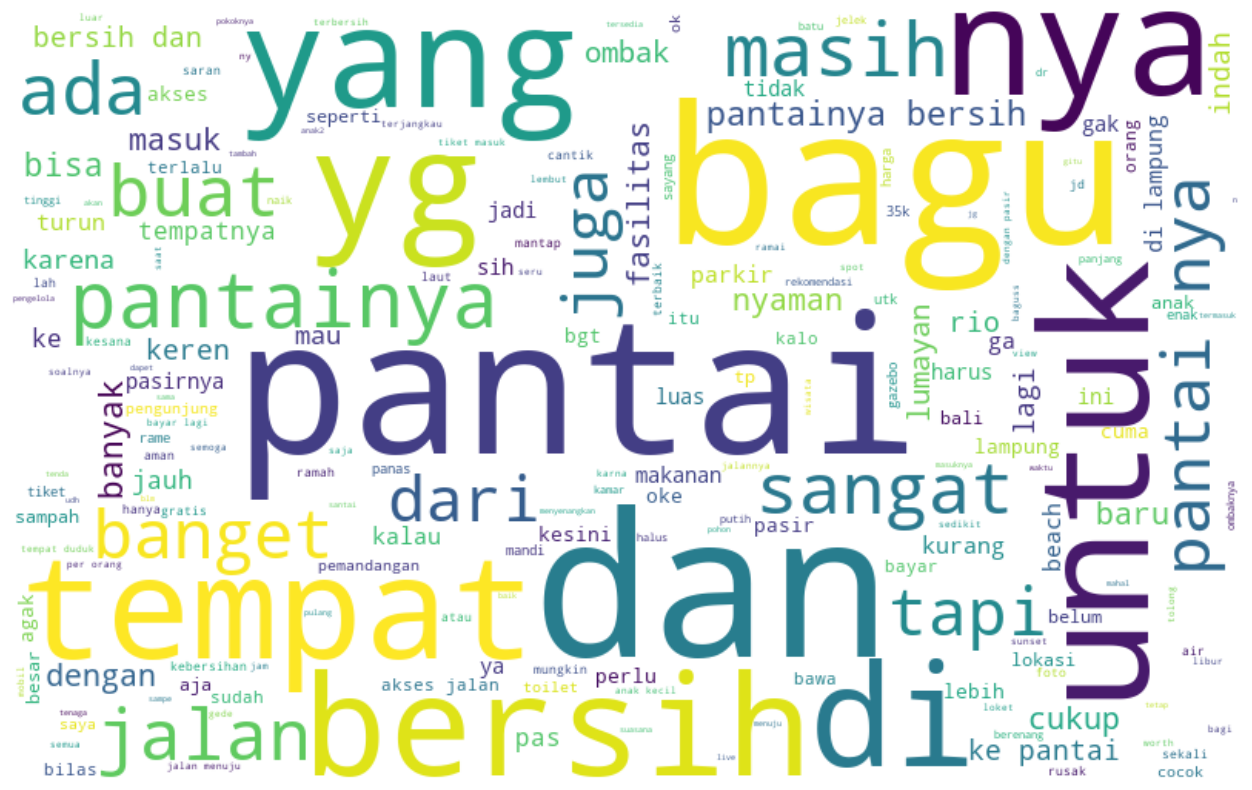

In [39]:
# Visualisasi WordCloud untuk label positif
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_p = TF_IDF.filter(col('rating') >= 3)

all_words_lem = " ".join([row['review'] for row in df_p.select('review').collect()])

wordcloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130).generate(all_words_lem)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

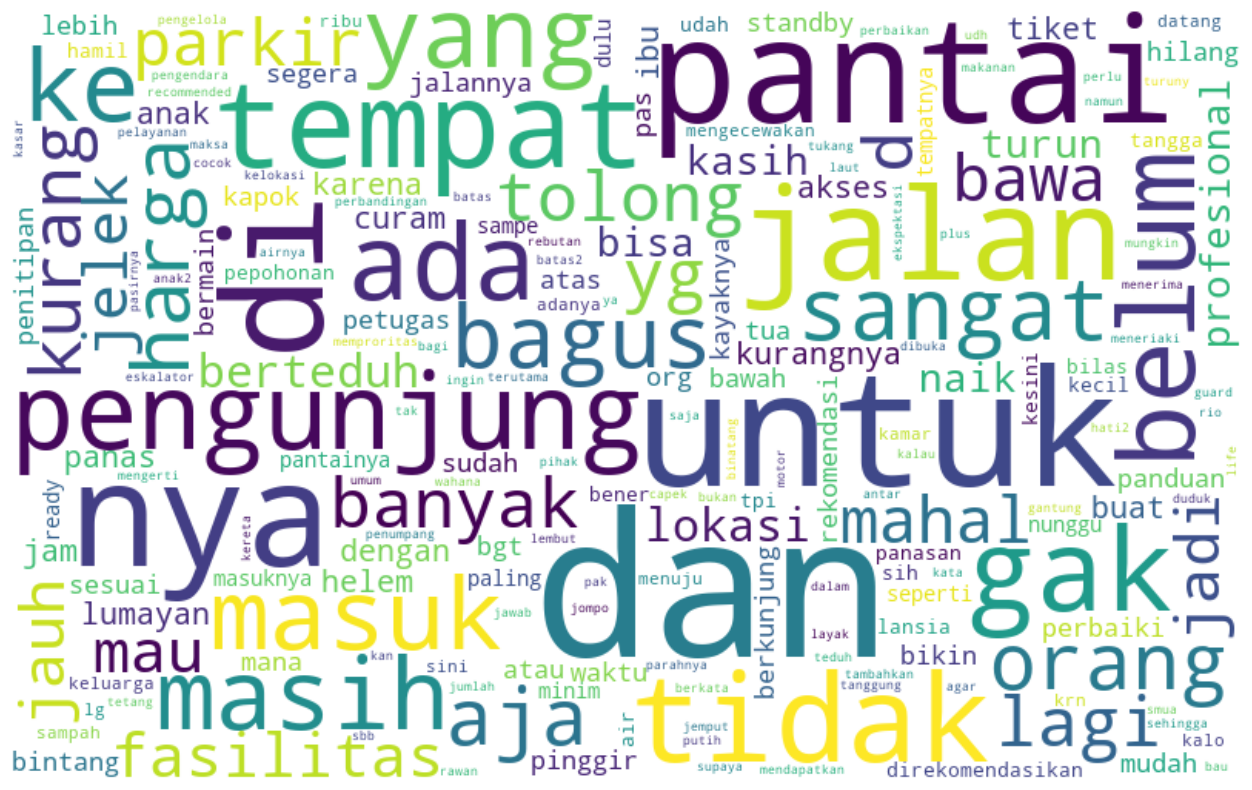

In [40]:
# Visualisasi WordCloud untuk label negatif
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_p = TF_IDF.filter(col('rating') < 3)

all_words_lem = " ".join([row['review'] for row in df_p.select('review').collect()])

wordcloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130).generate(all_words_lem)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()